# Handwritten Characters Recognition

### Import Libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import Dataset

In [59]:
train = pd.read_csv('./MNIST_train.csv')
test =  pd.read_csv('./MNIST_test.csv')

In [60]:
print(f"Train data has {train.shape} shape, Test data has {test.shape} shape")

Train data has (60000, 787) shape, Test data has (10000, 787) shape


In [61]:
train.head()

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
test.head()

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
train=train.drop(['Unnamed: 0', 'index'], axis=1)
test=test.drop(['Unnamed: 0', 'index'], axis=1)

In [64]:
print(f"Train data has {train.shape} shape, Test data has {test.shape} shape")

Train data has (60000, 785) shape, Test data has (10000, 785) shape


### Checking for missing data

In [82]:
train.isna().sum().sum()

0

In [83]:
test.isna().sum().sum()

0

### Checking for duplicates

In [84]:
train.duplicated().sum()


0

In [85]:
test.duplicated().sum()


0

In [65]:
max(train.iloc[1])

255

In [66]:
min(train.iloc[1])

0

### Visualization 

In [145]:
def show_me(X):
    plt.imshow(X.reshape(28,28))
    
def show_me_allmean(X,y,k):
    show_me(sum(X[y==k,:]/len(X[y==k,:])))

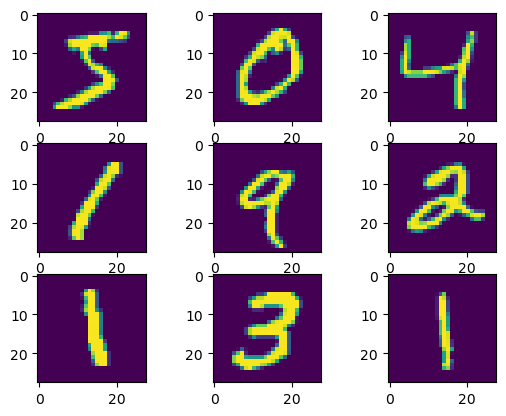

In [153]:
for i in range(9):
    plt.subplot(3,3,1+i)
    show_me(train_X[i])

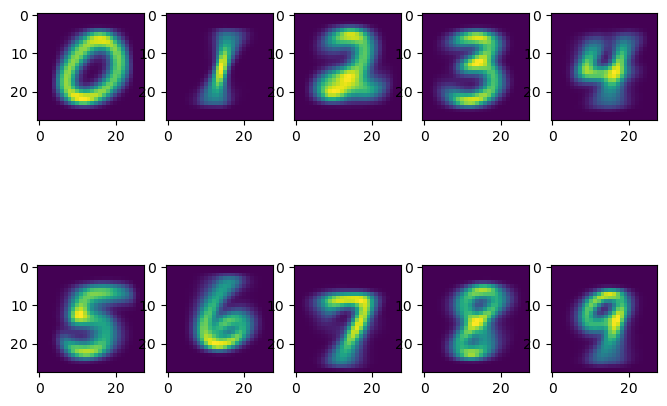

In [158]:
plt.figure(figsize=(8,6))
for i in range(10):
    plt.subplot(2,5,1+i)
    show_me_allmean(train_X,train_y,i)

### Distribution of labels

In [113]:
train.labels.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: labels, dtype: int64

### Restructure Dataset

In [86]:
train_y=train.labels.to_numpy()
train_X=train.iloc[:,1:785].to_numpy()

In [108]:
train_X.shape

(60000, 784)

In [87]:
test_y=test.labels.to_numpy()
test_X=test.iloc[:,1:785].to_numpy()

### Models

In [76]:
from scipy.stats import multivariate_normal as mvn


In [71]:
class GaussNB():

    def fit(self, X, y, epsilon=1e-3):
        self.likelihoods = dict()
        self.priors = dict()

        self.K = set(y.astype(int))

        for k in self.K:
            X_k = X[y==k]
            self.likelihoods[k] = {'mean':X_k.mean(axis=0), 'cov':X_k.var(axis=0)+epsilon}
            self.priors[k] = len(X_k)/len(X)


    def predict(self, X):
        N,D = X.shape
        P_hat = np.zeros((N,len(self.K)))

        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l['mean'], l['cov']) + np.log(self.priors[k])

        return P_hat.argmax(axis=1)
        




class GaussB():

    def fit(self, X, y, epsilon=1e-3):
        self.likelihoods = dict()
        self.priors = dict()

        self.K = set(y.astype(int))

        for k in self.K:
            X_k = X[y==k]
            N_k,D = X_k.shape
            mu_k = X_k.mean(axis=0)
            self.likelihoods[k] = {'mean':X_k.mean(axis=0), 'cov': 1/(N_k-1)*np.matmul((X_k-mu_k).T, (X_k-mu_k))+epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)


    def predict(self, X):
        N,D = X.shape
        P_hat = np.zeros((N,len(self.K)))

        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l['mean'], l['cov']) + np.log(self.priors[k])

        return P_hat.argmax(axis=1)
        



class KNNClassifier():
    def fit(self, X,y):
        self.X=X
        self.y=y

    def predict(self, X, K, epsilon=1e-3):
        N=len(X)
        y_hat = np.zeros(N)

        for i in range(N):
            dist2=np.sum((self.X-X[i])**2, axis=1)
            idxt= np.argsort(dist2)[:K]
            gamma_k= 1/(np.sqrt(dist2[idxt]+epsilon))

            y_hat[i]= np.bincount(self.y[idxt], weights= gamma_k).argmax()

        return y_hat

In [74]:
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

## Models Training

### Model 1

In [88]:
gnb=GaussNB()
gnb.fit(train_X,train_y)

In [89]:
gnb_pred=gnb.predict(test_X)
accuracy(test_y,gnb_pred)

0.5878

### Model 2

In [90]:
gb=GaussB()
gb.fit(train_X,train_y)

In [91]:
gb_pred=gb.predict(test_X)
accuracy(test_y,gb_pred)

0.7532

### Tuning Gaussian Naive Bayes

In [196]:
result={}
for e in np.arange(40,50,2):
    md=GaussNB()
    md.fit(train_X,train_y,e)
    md_pred=md.predict(test_X)
    result[e]=accuracy(test_y,md_pred)
    


In [197]:
result

{40: 0.7655, 42: 0.7663, 44: 0.7675, 46: 0.7685, 48: 0.7692}

### Tuning Gaussian Bayes

In [198]:
result1={}
for e in np.arange(40,50,2):
    md=GaussB()
    md.fit(train_X,train_y,e)
    md_pred=md.predict(test_X)
    result1[e]=accuracy(test_y,md_pred)
    


In [199]:
result1

{40: 0.9021, 42: 0.903, 44: 0.9037, 46: 0.9041, 48: 0.9048}

### Model 3

In [92]:
knn=KNNClassifier()
knn.fit(train_X,train_y)

In [94]:
knn_pred=knn.predict(test_X,1000)
accuracy(test_y,knn_pred)

0.8788

In [95]:
knn_pred1=knn.predict(test_X,100)
accuracy(test_y,knn_pred1)

0.9448

In [134]:
knn_pred2=knn.predict(test_X,50)
accuracy(test_y,knn_pred2)

0.9546

In [136]:
knn_pred3=knn.predict(test_X,75)
accuracy(test_y,knn_pred3)

0.9491

In [137]:
knn_pred4=knn.predict(test_X,25)
accuracy(test_y,knn_pred4)

0.9612

In [138]:
knn_pred5=knn.predict(test_X,20)
accuracy(test_y,knn_pred5)

0.9633

In [139]:
knn_pred6=knn.predict(test_X,15)
accuracy(test_y,knn_pred6)

0.9647

In [171]:
knn_pred7=knn.predict(test_X,7)
accuracy(test_y,knn_pred7)

0.97

### Confusion Matrix

Text(0.5, 47.7222222222222, 'Predicted label')

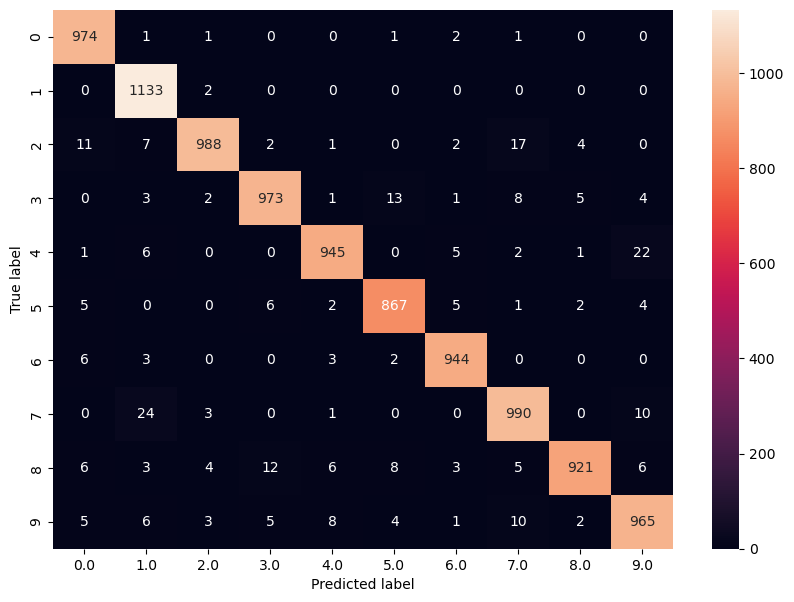

In [172]:
plt.figure(figsize=(10,7))
y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(knn_pred7, name='Predicted')
cm = pd.crosstab(y_actu, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')